# RGBD Segmentation
## SUNRGBD dataset preparation
This project is to compare the RGB dataset with RGBD dataset finding the performance on the segmentation task. To set up the experiment, SUNRGBD dataset contains all the requirements to do the task. In order to simplify the training process and receive the acceptable result, There are only 1,200 images of SUNRGBD dataset considered in the project.
## Before execute the colab
1. Please make sure the colab connect to the T4 GPU server
2. Please don't execute all the blocks (Although it should have not issue, train all the model would take at least 1.5 hours.)
3. GPU server on colab is limited, please make sure there is enough resource to run the training. Otherwise, the process might be interruptted due to GPU limitation.


In [ ]:
# Download the customized SUNRGBD dataset
# The images are already resized in 224 x 224 pixels and separated into train and test data
# train data contains 1,000 images
# test data contains 200 images
!unzip "/content/sun_resize.zip" -d "/content"

Downloading...
From (original): https://drive.google.com/uc?id=1G8fLLz9SWk4xQAVvfAKSQJSPnMOy-rOb
From (redirected): https://drive.google.com/uc?id=1G8fLLz9SWk4xQAVvfAKSQJSPnMOy-rOb&confirm=t&uuid=d66f98c1-cfee-4ab0-86f8-d82fa258cc0a
To: /content/sun_resize.zip
100% 88.4M/88.4M [00:01<00:00, 58.3MB/s]
Archive:  /content/sun_resize.zip
   creating: /content/test_resize_depth/
  inflating: /content/test_resize_depth/test_0.png  
  inflating: /content/test_resize_depth/test_1.png  
  inflating: /content/test_resize_depth/test_10.png  
  inflating: /content/test_resize_depth/test_100.png  
  inflating: /content/test_resize_depth/test_101.png  
  inflating: /content/test_resize_depth/test_102.png  
  inflating: /content/test_resize_depth/test_103.png  
  inflating: /content/test_resize_depth/test_104.png  
  inflating: /content/test_resize_depth/test_105.png  
  inflating: /content/test_resize_depth/test_106.png  
  inflating: /content/test_resize_depth/test_107.png  
  inflating: /content/t

In [ ]:
train_rgb_dir = f'/content/train_resize_rgb'
train_depth_dir = f'/content/train_resize_depth'
train_label_dir = f'/content/train_resize_label'
test_rgb_dir = f'/content/test_resize_rgb'
test_depth_dir = f'/content/test_resize_depth'
test_label_dir = f'/content/test_resize_label'

# Import required libraries and GPU/TPU
Using GPU is highly recommended, TPU is not well prepared for training this model. Therefore, TPU may not be able to finish the training. However, GPU will take roughly 30 minutes to train one of the models.

In [ ]:
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

In [ ]:
# Tensorflow connect to GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Tensorflow connect to TPU
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Pre-process dataset

In [ ]:


# Image dimensions and number of classes
img_height, img_width = 224, 224
num_classes = 38  # Modify based on your dataset

def preprocess_data(rgb_dir, depth_dir, label_dir):
    rgb_images, depth_images, labels = [], [], []

    # Process RGB files in .jpg format
    for rgb_filename in os.listdir(rgb_dir):
        if not rgb_filename.endswith('.jpg'):  # Process only .jpg files
            continue

        # Replace .jpg with .png for depth and label filenames
        base_filename = os.path.splitext(rgb_filename)[0]
        depth_filename = f"{base_filename}.png"
        label_filename = f"{base_filename}.png"

        # Construct paths
        rgb_path = os.path.join(rgb_dir, rgb_filename)
        depth_path = os.path.join(depth_dir, depth_filename)
        label_path = os.path.join(label_dir, label_filename)

        # Load RGB image
        rgb = cv2.imread(rgb_path)
        if rgb is None:
            print(f"Warning: RGB image {rgb_path} could not be loaded.")
            continue
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB) / 255.0  # Normalize

        # Load Depth image
        depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        if depth is None:
            print(f"Warning: Depth image {depth_path} could not be loaded.")
            continue
        depth = depth.astype(np.float32) / np.max(depth) # Normalize

        # Load Label image
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        if label is None:
            print(f"Warning: Label image {label_path} could not be loaded.")
            continue

        # Append to lists
        rgb_images.append(rgb)
        depth_images.append(depth)
        labels.append(label)

    return np.array(rgb_images), np.array(depth_images), np.array(labels)



In [ ]:
train_images, train_depths, train_labels = preprocess_data(train_rgb_dir, train_depth_dir, train_label_dir)
test_images, test_depths, test_labels = preprocess_data(test_rgb_dir, test_depth_dir, test_label_dir)

# Visualize the dataset

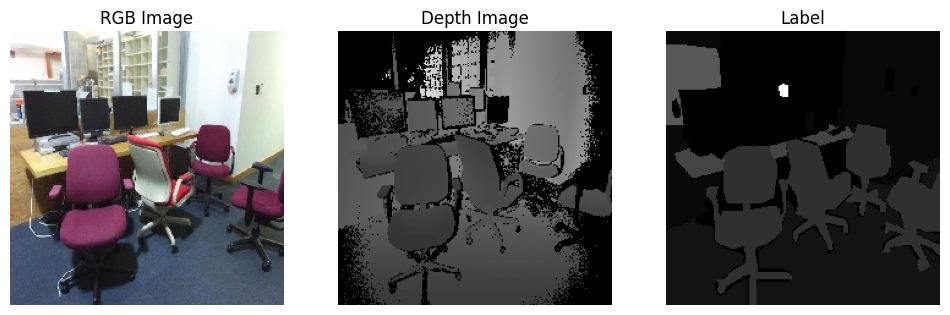

In [ ]:
import matplotlib.pyplot as plt

def visualize_sample(images, depths, labels=None, index=0):
    plt.figure(figsize=(12, 4))

    # RGB Image
    plt.subplot(1, 3, 1)
    plt.imshow(images[index])
    plt.title("RGB Image")
    plt.axis("off")

    # Depth Image
    plt.subplot(1, 3, 2)
    plt.imshow(depths[index, :, :], cmap='gray')
    plt.title("Depth Image")
    plt.axis("off")

    # Label (if provided)
    if labels is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(labels[index, :, :], cmap='gray')
        plt.title("Label")
        plt.axis("off")

    plt.show()

# Visualize a sample from the training data
visualize_sample(train_images, train_depths, train_labels, index=0)

# Unet Model Architecture
There are three functions of the unet architecture to explore the RGB-D dataset on segmentation task.

In [ ]:
def unet_model_rgb(img_height, img_width, num_classes):
    # Inputs
    rgb_input = Input(shape=(img_height, img_width, 3))


    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(rgb_input)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2, up1], axis=-1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1, up2], axis=-1)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax', padding='same')(conv5)

    # Create model
    model = Model(inputs=rgb_input, outputs=outputs)
    return model

# Initialize the model
model = unet_model_rgb(img_height, img_width, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def unet_first_merge(img_height, img_width, num_classes):
    # Inputs
    rgb_input = Input(shape=(img_height, img_width, 3))
    depth_input = Input(shape=(img_height, img_width, 1))

    # Merge RGB and depth
    inputs = concatenate([rgb_input, depth_input])

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2, up1], axis=-1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1, up2], axis=-1)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax', padding='same')(conv5)

    # Create model
    model = Model(inputs=[rgb_input, depth_input], outputs=outputs)
    return model

# Initialize the model
model_first_merge = unet_first_merge(img_height, img_width, num_classes)
model_first_merge.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def unet_with_mid_merge(img_height, img_width, num_classes):
    # RGB Encoder
    rgb_input = Input(shape=(img_height, img_width, 3))
    conv1_rgb = Conv2D(64, 3, activation='relu', padding='same')(rgb_input)
    conv1_rgb = Conv2D(64, 3, activation='relu', padding='same')(conv1_rgb)
    pool1_rgb = MaxPooling2D(pool_size=(2, 2))(conv1_rgb)

    conv2_rgb = Conv2D(128, 3, activation='relu', padding='same')(pool1_rgb)
    conv2_rgb = Conv2D(128, 3, activation='relu', padding='same')(conv2_rgb)
    pool2_rgb = MaxPooling2D(pool_size=(2, 2))(conv2_rgb)

    # Depth Encoder
    depth_input = Input(shape=(img_height, img_width, 1))
    conv1_depth = Conv2D(64, 3, activation='relu', padding='same')(depth_input)
    conv1_depth = Conv2D(64, 3, activation='relu', padding='same')(conv1_depth)
    pool1_depth = MaxPooling2D(pool_size=(2, 2))(conv1_depth)

    conv2_depth = Conv2D(128, 3, activation='relu', padding='same')(pool1_depth)
    conv2_depth = Conv2D(128, 3, activation='relu', padding='same')(conv2_depth)
    pool2_depth = MaxPooling2D(pool_size=(2, 2))(conv2_depth)

    # Merge RGB and Depth Features
    merged = concatenate([pool2_rgb, pool2_depth])

    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(merged)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2_rgb, conv2_depth, up1], axis=-1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1_rgb, conv1_depth, up2], axis=-1)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output Layer
    outputs = Conv2D(num_classes, 1, activation='softmax', padding='same')(conv5)

    # Create Model
    model = Model(inputs=[rgb_input, depth_input], outputs=outputs)
    return model

model_mid_merge = unet_with_mid_merge(img_height, img_width, num_classes)
model_mid_merge.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Generate the validation data from the training dataset

In [ ]:
# Split into training and validation sets
split_idx = int(0.8 * len(train_images))
train_rgb, val_rgb = train_images[:split_idx], train_images[split_idx:]
train_depth, val_depth = train_depths[:split_idx], train_depths[split_idx:]
train_label, val_label = train_labels[:split_idx], train_labels[split_idx:]

# Train the model

In [ ]:
# Train the model
history = model.fit(
    train_rgb,
    train_label,
    validation_data=(val_rgb, val_label),
    epochs=50,
    batch_size=16
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 431ms/step - accuracy: 0.2323 - loss: 2.8252 - val_accuracy: 0.3080 - val_loss: 2.2855
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 403ms/step - accuracy: 0.3285 - loss: 2.1372 - val_accuracy: 0.3329 - val_loss: 2.1542
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 432ms/step - accuracy: 0.3582 - loss: 2.0847 - val_accuracy: 0.3693 - val_loss: 2.1486
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 436ms/step - accuracy: 0.3868 - loss: 2.0548 - val_accuracy: 0.3997 - val_loss: 2.0576
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 410ms/step - accuracy: 0.4173 - loss: 1.9642 - val_accuracy: 0.4065 - val_loss: 2.0358
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 411ms/step - accuracy: 0.4222 - loss: 1.9421 - val_accuracy: 0.3931 - val_loss: 2.0634
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 415ms/step - accuracy: 0.4262 - loss: 1.9288 - val_accuracy: 0.4061 - val_loss: 1.9983
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 414ms/step - accuracy: 0.4214 - loss: 1.9133 - val_accu

In [ ]:
# Train the model
history = model_first_merge.fit(
    [train_rgb, train_depth],
    train_label,
    validation_data=([val_rgb, val_depth], val_label),
    epochs=50,
    batch_size=16
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 541ms/step - accuracy: 0.2105 - loss: 3.0177 - val_accuracy: 0.3044 - val_loss: 2.3306
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 464ms/step - accuracy: 0.3095 - loss: 2.2071 - val_accuracy: 0.3241 - val_loss: 2.1817
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 459ms/step - accuracy: 0.3576 - loss: 2.0802 - val_accuracy: 0.3649 - val_loss: 2.1270
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - accuracy: 0.4084 - loss: 2.0092 - val_accuracy: 0.3984 - val_loss: 2.0482
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 463ms/step - accuracy: 0.4284 - loss: 1.9208 - val_accuracy: 0.4124 - val_loss: 1.9804
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - accuracy: 0.4393 - loss: 1.8861 - val_accuracy: 0.4190 - val_loss: 1.9517
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 442ms/step - accuracy: 0.4457 - loss: 1.8790 - val_accuracy: 0.4169 - val_loss: 1.9613
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 439ms/step - accuracy: 0.4511 - loss: 1.8295 - val_accu

In [ ]:
# Train the model
history = model_mid_merge.fit(
    [train_rgb, train_depth],
    train_label,
    validation_data=([val_rgb, val_depth], val_label),
    epochs=50,
    batch_size=16
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 69s 835ms/step - accuracy: 0.2094 - loss: 2.9634 - val_accuracy: 0.3083 - val_loss: 2.2327
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 580ms/step - accuracy: 0.3283 - loss: 2.2006 - val_accuracy: 0.3534 - val_loss: 2.1329
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 585ms/step - accuracy: 0.3848 - loss: 2.0156 - val_accuracy: 0.4132 - val_loss: 2.0053
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 586ms/step - accuracy: 0.4274 - loss: 1.9427 - val_accuracy: 0.4173 - val_loss: 1.9777
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 588ms/step - accuracy: 0.4345 - loss: 1.8829 - val_accuracy: 0.4273 - val_loss: 1.9313
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 590ms/step - accuracy: 0.4466 - loss: 1.8687 - val_accuracy: 0.4170 - val_loss: 1.9485
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 578ms/step - accuracy: 0.4479 - loss: 1.8300 - val_accuracy: 0.4359 - val_loss: 1.8949
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 579ms/step - accuracy: 0.4465 - loss: 1.8212 - val_accu

# Check the test result (200 images)

In [ ]:
loss, accuracy = model.evaluate(test_images, test_labels)
# loss, accuracy = model_first_merge.evaluate([test_images, test_depths], test_labels) # change the model name if it's different
# loss, accuracy = model_mid_merge.evaluate([test_images, test_depths], test_labels)
print(f"Test accuracy: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.4479 - loss: 2.1616
Test accuracy: 0.447061151266098


# Predict the test images and visualize 5 images

In [ ]:
# Predict on test data
preds = model.predict(test_images[:5])
# preds = model_first_merge.predict([test_images[:5], test_depths[:5]]) # change the model name if it's different
# preds = model_mid_merge.predict([test_images[:5], test_depths[:5]]) # change the model name if it's different

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step


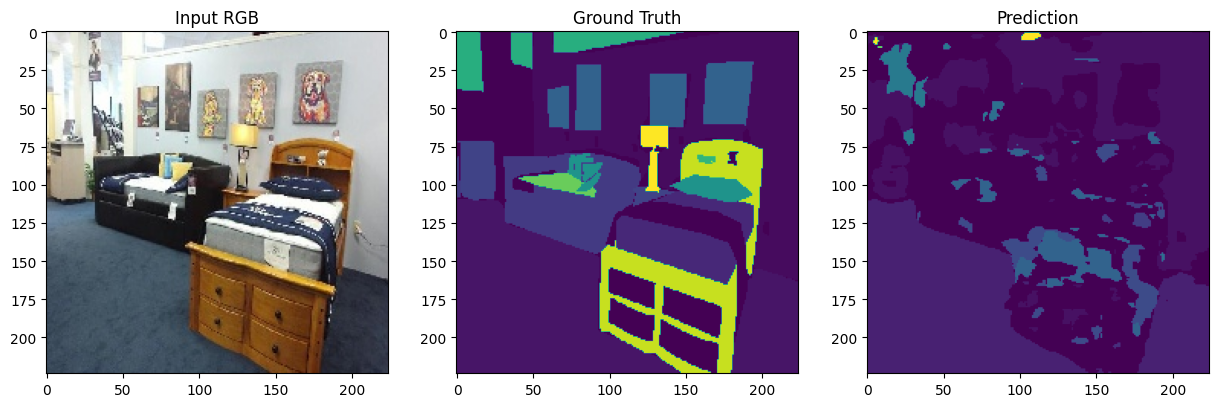

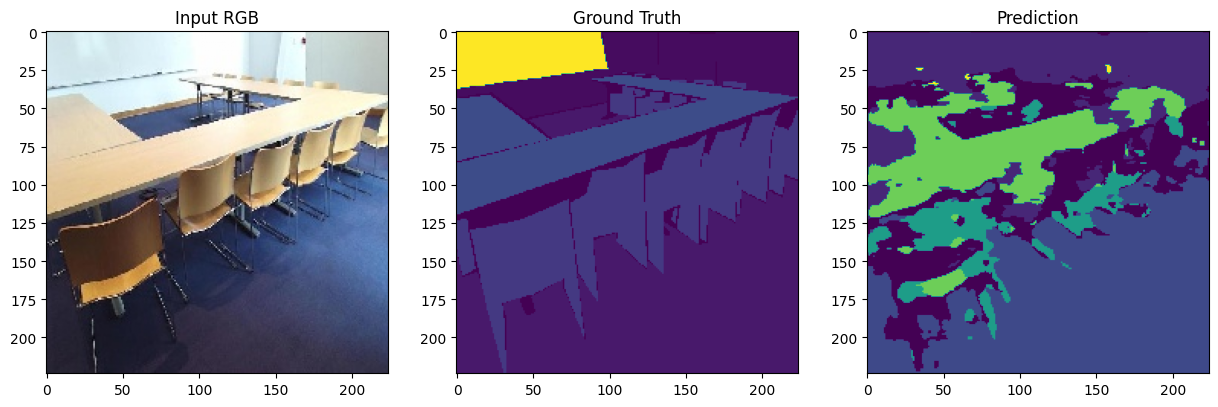

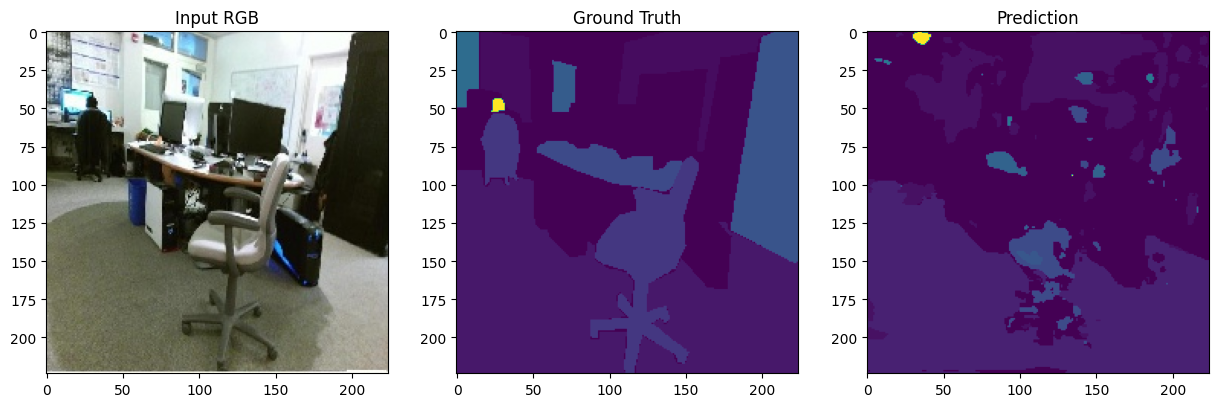

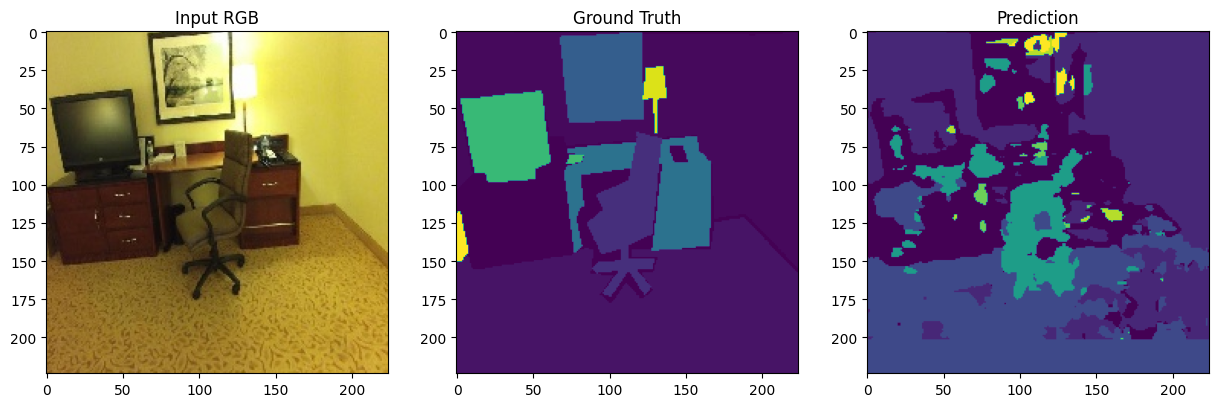

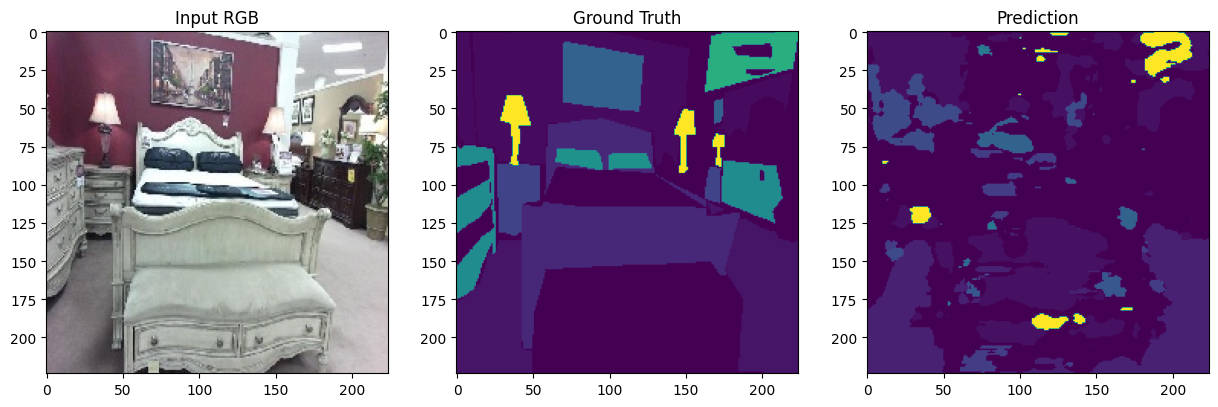

In [ ]:
# Plot predictions
for i in range(5):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Input RGB")
    plt.imshow(test_images[i])

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(test_labels[i,:,:],  cmap='viridis')

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(np.argmax(preds[i], axis=-1), cmap='viridis')

    plt.show()

# Save the model

In [ ]:
# save the model
model.save('model_rgb.keras')
# model_first_merge.save('model_first_merge.keras')
# model_mid_merge.save('model_mid_merge.keras')